# Task 2: Quantization

#### Installing the required libraries

In [1]:
!pip install torchinfo
!pip install torchao
!pip install optimum-quanto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 21.0 MB/s eta 0:00:00


#### Loading in the required libraries

In [2]:
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import models
from torchinfo import summary
import torchvision
import torchvision.transforms as transforms
import copy
from torchao.quantization.quant_api import (quantize_, int8_dynamic_activation_int8_weight, int4_weight_only, int8_weight_only)
from optimum.quanto import quantize, qint4
from torch.amp.autocast_mode import autocast

#### Mounting the drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setting the device to use

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Loading in the VGG-11 model

In [5]:
# Loading in VGG-11
vgg11 = models.vgg11(weights= models.VGG11_Weights.DEFAULT)

# Preparing the classifier layer for CIFAR-100 classification
vgg11.classifier[6] = nn.Linear(4096, 100)

# Summary of VGG-11
summary(vgg11, input_size=(1, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 225MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 100]                  --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-5                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-6                    [1, 128, 56, 56]          --
│    └─Conv2d: 2-7                       [1, 256, 56, 56]          295,168
│    └─ReLU: 2-8                         [1, 256, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          590,080
│    └─ReLU: 2-10                        [1, 256, 56, 56]          --
│    └─MaxPool2d: 2-11                   [1, 256, 28, 28]          -

#### Loading in the CIFAR-100 dataset

In [6]:
# data_dir = '/content/drive/MyDrive/ATML_PA3'
data_dir = './data'

# Define transformations (you can modify this as per your needs)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

# Download and load the CIFAR-100 training set
train_dataset = torchvision.datasets.CIFAR100(
    root=data_dir,  # Path where the data should be downloaded
    train=True,
    download=True,
    transform=transform
)

# Download and load the CIFAR-100 test set
test_dataset = torchvision.datasets.CIFAR100(
    root=data_dir,  # Path where the data should be downloaded
    train=False,
    download=True,
    transform=transform
)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print("CIFAR-100 dataset loaded into", data_dir)

100%|██████████| 169M/169M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
CIFAR-100 dataset loaded into ./data


### Finetuning the Model for 5 epochs



#### Freezing the classifier backbone

In [ ]:
# Freezing the model backbone
for param in vgg11.parameters():
    param.requires_grad = False

# Replacing the classifier head for CIFAR-100 classification
vgg11.classifier[6] = nn.Linear(4096, 100)

# Unfreezing the last layer in the classifier head
for param in vgg11.classifier[6].parameters():
    param.requires_grad = True

# Confirming the model is unfrozen
summary(vgg11, input_size=(1, 3, 224, 224))

# trainable_params = sum(p.numel() for p in vgg11.parameters() if p.requires_grad)
# print(f"Trainable parameters: {trainable_params}")


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 100]                  --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-5                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-6                    [1, 128, 56, 56]          --
│    └─Conv2d: 2-7                       [1, 256, 56, 56]          (295,168)
│    └─ReLU: 2-8                         [1, 256, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          (590,080)
│    └─ReLU: 2-10                        [1, 256, 56, 56]          --
│    └─MaxPool2d: 2-11                   [1, 256, 28, 28]   

#### Finetuning the modified model

In [ ]:
# Finetuning the model on the CIFAR-100 dataset for 3 epochs
vgg11.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg11.parameters(), lr=0.001)

# Training the model
num_epochs = 5
train_losses = []
test_losses = []
train_acc = []

for epoch in range(num_epochs):
    vgg11.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg11(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100 * correct / total)
    print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}, Training Accuracy: {100 * correct / total}")

    vgg11.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(tqdm(test_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg11(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        test_losses.append(running_loss / len(test_loader))
        print(f"Epoch {epoch + 1}, Test Loss: {running_loss / len(test_loader)}, Test Accuracy: {100 * correct / total}")

100%|██████████| 782/782 [03:05<00:00,  4.20it/s]


Epoch 1, Training Loss: 1.9600570601270633, Training Accuracy: 47.622


100%|██████████| 157/157 [00:37<00:00,  4.24it/s]


Epoch 1, Test Loss: 1.4580630572738162, Test Accuracy: 58.34


100%|██████████| 782/782 [03:07<00:00,  4.18it/s]


Epoch 2, Training Loss: 1.6380248533947694, Training Accuracy: 54.71


100%|██████████| 157/157 [00:37<00:00,  4.22it/s]


Epoch 2, Test Loss: 1.382804438566706, Test Accuracy: 60.32


100%|██████████| 782/782 [03:05<00:00,  4.21it/s]


Epoch 3, Training Loss: 1.5717946741434619, Training Accuracy: 56.586


100%|██████████| 157/157 [00:37<00:00,  4.24it/s]


Epoch 3, Test Loss: 1.367748185327858, Test Accuracy: 61.53


100%|██████████| 782/782 [03:05<00:00,  4.21it/s]


Epoch 4, Training Loss: 1.5450494482998958, Training Accuracy: 57.578


100%|██████████| 157/157 [00:37<00:00,  4.23it/s]


Epoch 4, Test Loss: 1.396505104888017, Test Accuracy: 60.89


100%|██████████| 782/782 [03:07<00:00,  4.18it/s]


Epoch 5, Training Loss: 1.5171778877372937, Training Accuracy: 58.438


100%|██████████| 157/157 [00:37<00:00,  4.22it/s]

Epoch 5, Test Loss: 1.3678201175039741, Test Accuracy: 61.85


#### Saving the finetuned model

In [ ]:
# Saving the model
save_dir = '/content/drive/MyDrive/ATML_PA3/'  # Example directory, replace as needed
save_path = os.path.join(save_dir, 'vgg11_cifar100.pth')
torch.save(vgg11, save_path)
print(f"Model saved to {save_path}")

Model saved to /content/drive/MyDrive/ATML_PA3/vgg11_cifar100.pth


#### Plotting the testing and training losses

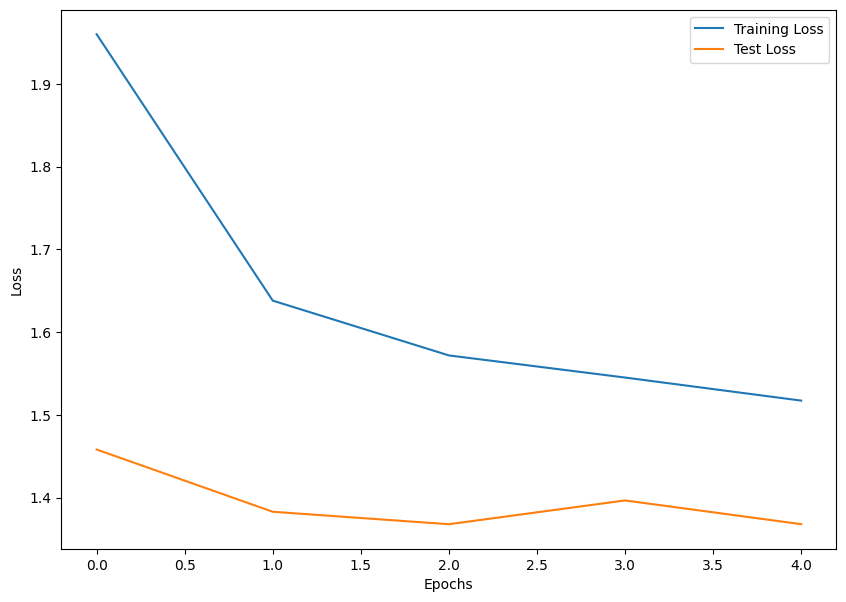

In [ ]:
# Plotting the training and test losses over epochs
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#### Loading in the model using the pth file

In [7]:
# Load the saved model
model_path = '/content/drive/MyDrive/vgg11_cifar100.pth'
finetuned_model = torch.load(model_path)
# finetuned_model.eval()

<ipython-input-7-bfc888ea7759>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finetuned_model = torch.load(model_path)


### Post Training Quantization

#### PTQ with FP16 bit width

In [ ]:
# Quantizing with FP16 bit width by simply casting to this data type
# Creating a deep copy of the model to keep the original intact
# quantized_model_fp16 = copy.deepcopy(vgg11)
quantized_model_fp16 = copy.deepcopy(finetuned_model)

# Casting the model to float16
quantized_model_fp16 = quantized_model_fp16.to(dtype=torch.float16)

# Printing the model summary following quanitzation
summary(quantized_model_fp16, input_size=(1, 3, 224, 224), dtypes=[torch.float16])

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 100]                  --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-5                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-6                    [1, 128, 56, 56]          --
│    └─Conv2d: 2-7                       [1, 256, 56, 56]          (295,168)
│    └─ReLU: 2-8                         [1, 256, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          (590,080)
│    └─ReLU: 2-10                        [1, 256, 56, 56]          --
│    └─MaxPool2d: 2-11                   [1, 256, 28, 28]   

#### Testing the quantized model

In [ ]:
# Evaluate the quantized model
def evaluate_normal_vgg11(model, dataloader):
    """Evaluates the normal (float32) VGG11 model.

    Args:
        model: The normal VGG11 model.
        dataloader: The dataloader for the evaluation data.

    Returns:
        The accuracy of the model on the evaluation data.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating Normal VGG11", leave=False):
            images = images.to(device)  # Move images to device
            labels = labels.to(device)  # Move labels to device


            outputs = model(images)  # Perform forward pass
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * (correct / total)
    return accuracy

def evaluate_float16_vgg11(model, dataloader):
    """Evaluates the float16 quantized VGG11 model.

    Args:
        model: The float16 quantized VGG11 model.
        dataloader: The dataloader for the evaluation data.

    Returns:
        The accuracy of the model on the evaluation data.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating Float16 VGG11", leave=False):
            images = images.to(device)  # Move images to device
            labels = labels.to(device)  # Move labels to device

            images = images.to(dtype = torch.float16)  # Cast images to float16

            outputs = model(images)  # Perform forward pass
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * (correct / total)
    return accuracy

def evaluate_model_float16_test(model, test_loader, criterion, device):

    model.eval()
    total_correct = 0
    total_samples = 0
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.to(torch.float16)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Get predictions and accumulate them
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            # Collect predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * total_correct / total_samples
    average_loss = running_loss / len(test_loader)
    print(f"Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return accuracy, average_loss, all_preds, all_labels

# Send models to the correct device
quantized_model_fp16 = quantized_model_fp16.to(device)
# vgg11 = vgg11.to(device)
finetuned_model = finetuned_model.to(device)

# Evaluating both of the models
original_acc = evaluate_normal_vgg11(finetuned_model, test_loader)
fp16_quantized_acc = evaluate_float16_vgg11(quantized_model_fp16, test_loader)

print("Original Accuracy:", original_acc)
print("Quantized Accuracy:", fp16_quantized_acc)


Original Accuracy: 61.85000000000001
Quantized Accuracy: 61.88


#### QAT with the FP16 quantized model

In [ ]:
# Move model to device
quantized_model_fp16 = quantized_model_fp16.to(device)

# Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(quantized_model_fp16.parameters(), lr=0.01)
num_epochs = 3  # Adjust based on performance needs
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(quantized_model_fp16.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

for epoch in range(num_epochs):
    quantized_model_fp16.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        images, labels = images.to(device), labels.to(device)  # Only move to GPU

        images = images.to(dtype = torch.float16)  # Cast images to float16

        optimizer.zero_grad()


        outputs = quantized_model_fp16(images)

        loss = criterion(outputs, labels)

        # Backpropagation
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(quantized_model_fp16.parameters(), max_norm=0.5)

        optimizer.step()

        running_loss += loss.item()

    # Print the average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss/len(train_loader):.4f}")

# Final evaluation after fine-tuning
final_accuracy = evaluate_float16_vgg11(quantized_model_fp16, test_loader)
print(f"Final Accuracy after QAT: {final_accuracy}%")


Epoch [1/3], Average Loss: 1.3243


Epoch [2/3], Average Loss: 1.2845


Epoch [3/3], Average Loss: 1.2561


Final Accuracy after QAT: 64.31%


#### PTQ with BF16 bit width

In [ ]:
# Now casting the model to BF16 width for quantization
# quantized_model_bf16 = copy.deepcopy(vgg11).to(dtype=torch.bfloat16)
# quantized_model_bf16 = copy.deepcopy(vgg11)
quantized_model_bf16 = copy.deepcopy(finetuned_model)
quantized_model_bf16 = quantized_model_bf16.to(dtype=torch.bfloat16)

# Printing the model summary following quanitzation
summary(quantized_model_bf16, input_size=(1, 3, 224, 224), dtypes=[torch.bfloat16])

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 100]                  --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-5                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-6                    [1, 128, 56, 56]          --
│    └─Conv2d: 2-7                       [1, 256, 56, 56]          (295,168)
│    └─ReLU: 2-8                         [1, 256, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          (590,080)
│    └─ReLU: 2-10                        [1, 256, 56, 56]          --
│    └─MaxPool2d: 2-11                   [1, 256, 28, 28]   

#### Testing the quantized BF16 model

In [ ]:
def evaluate_bfloat16_vgg11(model, dataloader):
    """Evaluates the bfloat16 quantized VGG11 model.

    Args:
        model: The bfloat16 quantized VGG11 model.
        dataloader: The dataloader for the evaluation data.

    Returns:
        The accuracy of the model on the evaluation data.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating BFloat16 VGG11", leave=False):
            images = images.to(device)  # Move images to device
            labels = labels.to(device)  # Move labels to device

            # Cast images to bfloat16
            images = images.bfloat16()

            outputs = model(images)  # Perform forward pass
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * (correct / total)
    return accuracy

# Testing with the bf16 quantized model
bf16_quantized_acc = evaluate_bfloat16_vgg11(quantized_model_bf16, test_loader)
print("BF16 Quantized Accuracy:", bf16_quantized_acc)

BF16 Quantized Accuracy: 61.980000000000004


#### QAT with the BF16 quantized model

In [ ]:
# Move model to device without explicit FP16 casting
quantized_model_bf16 = quantized_model_bf16.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(quantized_model_bf16.parameters(), lr=1e-7)
optimizer = optim.SGD(quantized_model_fp16.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

num_epochs = 3  # Adjust based on performance needs
for epoch in range(num_epochs):
    quantized_model_bf16.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        images, labels = images.to(device), labels.to(device)  # Only move to GPU

        # Convert images to bfloat16 format
        images = images.bfloat16()

        optimizer.zero_grad()

        # Forward pass
        outputs = quantized_model_bf16(images)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()

        # Gradient clipping
        nn.utils.clip_grad_norm_(quantized_model_bf16.parameters(), max_norm=0.5)

        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy for this batch
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Calculate and print the average loss and training accuracy for the epoch
    avg_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Evaluate on the test set and print test accuracy
    quantized_model_bf16.eval()
    with torch.no_grad():
        correct_test = 0
        total_test = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.bfloat16()
            outputs = quantized_model_bf16(images)
            _, predicted = torch.max(outputs.data, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = 100 * correct_test / total_test
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {test_accuracy:.2f}%\n")

Epoch [1/3], Average Loss: 1.4064, Training Accuracy: 60.54%
Epoch [1/3], Test Accuracy: 61.98%



Epoch [2/3], Average Loss: 1.4013, Training Accuracy: 60.64%
Epoch [2/3], Test Accuracy: 61.98%



Epoch [3/3], Average Loss: 1.4062, Training Accuracy: 60.69%
Epoch [3/3], Test Accuracy: 61.98%



PTQ with INT8 Bit Width

In [ ]:
# Quantizing the model to int 8 bit width using the torch ao apis
# int8_quantized_model = copy.deepcopy(vgg11)
int8_quantized_model = copy.deepcopy(finetuned_model)

# Quantizing the model
quantize_(int8_quantized_model, int8_weight_only())

# Printing the model summary following quanitzation
summary(int8_quantized_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 100]                  --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-5                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-6                    [1, 128, 56, 56]          --
│    └─Conv2d: 2-7                       [1, 256, 56, 56]          (295,168)
│    └─ReLU: 2-8                         [1, 256, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          (590,080)
│    └─ReLU: 2-10                        [1, 256, 56, 56]          --
│    └─MaxPool2d: 2-11                   [1, 256, 28, 28]   

#### Evaluating the model after quantization

In [ ]:
int8_quantized_model = int8_quantized_model.to(device)

def evaluate_int8_vgg11(model, dataloader):
    """Evaluates the int8 quantized VGG11 model.

    Args:
        model: The int8 quantized VGG11 model.
        dataloader: The dataloader for the evaluation data.

    Returns:
        The accuracy of the model on the evaluation data.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating Int8 VGG11", leave=False):
            images = images.to(device)  # Move images to device
            labels = labels.to(device)  # Move labels to device

            outputs = model(images)  # Perform forward pass
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * (correct / total)
    return accuracy

# Testing with the int8 quantized model
int8_quantized_acc = evaluate_int8_vgg11(int8_quantized_model, test_loader)
print("Int8 Quantized Accuracy:", int8_quantized_acc)

Int8 Quantized Accuracy: 61.83


#### Preparing INT8 quantized model for QAT

In [ ]:
from torchao.quantization.prototype.qat import Int8DynActInt4WeightQATQuantizer

# Quantizing the model to int 8 bit width using the torch ao apis
# int8_quantized_model = copy.deepcopy(vgg11)
int8_quantized_model = copy.deepcopy(finetuned_model)

# Quantizing the model
qat_quantizer = Int8DynActInt4WeightQATQuantizer()

int8_quantized_model = qat_quantizer.prepare(int8_quantized_model)

# Printing the model summary following quanitzation
summary(int8_quantized_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 100]                  --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-3                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-5                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-6                    [1, 128, 56, 56]          --
│    └─Conv2d: 2-7                       [1, 256, 56, 56]          (295,168)
│    └─ReLU: 2-8                         [1, 256, 56, 56]          --
│    └─Conv2d: 2-9                       [1, 256, 56, 56]          (590,080)
│    └─ReLU: 2-10                        [1, 256, 56, 56]          --
│    └─MaxPool2d: 2-11                   [1, 256, 28, 28]   

#### Finetuning the model

In [ ]:
# Move the model to the device (e.g., GPU if available)
int8_quantized_model = int8_quantized_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(int8_quantized_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

num_epochs = 3  # Adjust based on performance needs
for epoch in range(num_epochs):
    int8_quantized_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = int8_quantized_model(images)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Print average loss and training accuracy for the epoch
    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Evaluate on the test set and print test accuracy
    int8_quantized_model.eval()
    with torch.no_grad():
        correct_test = 0
        total_test = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = int8_quantized_model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = 100 * correct_test / total_test
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {test_accuracy:.2f}%\n")


Epoch [1/3], Average Loss: 1.8824, Training Accuracy: 48.34%
Epoch [1/3], Test Accuracy: 58.53%



Epoch [2/3], Average Loss: 1.3983, Training Accuracy: 59.91%
Epoch [2/3], Test Accuracy: 62.50%



Epoch [3/3], Average Loss: 1.0341, Training Accuracy: 69.56%
Epoch [3/3], Test Accuracy: 64.59%



#### Converting the model to the quantized version

In [ ]:
int8_quantized_model = qat_quantizer.convert(int8_quantized_model)

# Evaluating after converting the model
int8_quantized_acc = evaluate_int8_vgg11(int8_quantized_model, test_loader)
print("Int8 Quantized Accuracy:", int8_quantized_acc)

Int8 Quantized Accuracy: 64.59


#### PTQ with INT4 Bit Width

In [8]:
from torchao.quantization.prototype.qat import Int4WeightOnlyQATQuantizer

# Quantizing the model to int 8 bit width using the torch ao apis
# int4_quantized_model = copy.deepcopy(vgg11)
int4_quantized_model = copy.deepcopy(finetuned_model)


int4_quantized_model = int4_quantized_model.to(torch.bfloat16)

# quantize(int4_quantized_model, weights=qint4, activations=qint4)

quantize_(int4_quantized_model, int4_weight_only())

# # Quantizing the model
# qat_quantizer = Int4WeightOnlyQATQuantizer()

# int4_quantized_model = qat_quantizer.prepare(int4_quantized_model)

# Printing the model summary following quanitzation
# summary(int4_quantized_model, input_size=(1, 3, 224, 224), dtypes=[qint4])

#### Evaluating the model after quantization

In [9]:
# int4_quantized_model = qat_quantizer.convert(int4_quantized_model)
int4_quantized_model = int4_quantized_model.to(device)

def evaluate_int4_vgg11(model, dataloader):
    """Evaluates the int4 quantized VGG11 model.

    Args:
        model: The int4 quantized VGG11 model.
        dataloader: The dataloader for the evaluation data.

    Returns:
        The accuracy of the model on the evaluation data.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating Int4 VGG11", leave=False):
            images = images.to(device)  # Move images to device
            labels = labels.to(device)  # Move labels to device

            images = images.to(torch.bfloat16)

            outputs = model(images)  # Perform forward pass
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Testing with the int4 quantized model
int4_quantized_acc = evaluate_int4_vgg11(int4_quantized_model, test_loader)
print("Int4 Quantized Accuracy:", int4_quantized_acc)

Int4 Quantized Accuracy: 61.64


#### Preparing the Int 4 model for QAT

In [10]:
from torchao.quantization.prototype.qat import Int4WeightOnlyQATQuantizer

int4_quantized_model = copy.deepcopy(finetuned_model)


int4_quantized_model = int4_quantized_model.to(torch.bfloat16)

# Quantizing the model
qat_quantizer = Int4WeightOnlyQATQuantizer()

int4_quantized_model = qat_quantizer.prepare(int4_quantized_model)


#### QAT with the INT4 model

In [11]:
# Move the model to the device (e.g., GPU if available)
int4_quantized_model = int4_quantized_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(int4_quantized_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

num_epochs = 3  # Adjust based on performance needs
for epoch in range(num_epochs):
    int4_quantized_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
        images, labels = images.to(device), labels.to(device)

        images = images.to(torch.bfloat16)

        optimizer.zero_grad()

        # Forward pass
        outputs = int4_quantized_model(images)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Print average loss and training accuracy for the epoch
    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Evaluate on the test set and print test accuracy
    int4_quantized_model.eval()
    with torch.no_grad():
        correct_test = 0
        total_test = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            images = images.to(torch.bfloat16)
            outputs = int4_quantized_model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = 100 * correct_test / total_test
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {test_accuracy:.2f}%\n")


Epoch [1/3], Average Loss: 1.8733, Training Accuracy: 48.61%
Epoch [1/3], Test Accuracy: 59.10%



Epoch [2/3], Average Loss: 1.4090, Training Accuracy: 59.99%
Epoch [2/3], Test Accuracy: 62.63%



Epoch [3/3], Average Loss: 1.0560, Training Accuracy: 68.69%
Epoch [3/3], Test Accuracy: 64.90%



#### Converting the model following finetuning

In [12]:
int4_quantized_model = qat_quantizer.convert(int4_quantized_model)

# Evaluating after converting the model
int4_quantized_acc = evaluate_int4_vgg11(int4_quantized_model, test_loader)
print("Int8 Quantized Accuracy:", int4_quantized_acc)

Int8 Quantized Accuracy: 64.89
